In [398]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.ticker as ticker
from scipy import constants as sc

import window_function_2
import HERA_hack_FG
import pspec_copy
import make_universe_copy
import cross_pspec
from CCAT_p import CCAT_p

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=19
plt.rcParams['xtick.labelsize']=19



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

npix_row,npix_col = 50,50

Lx = 325.5
Ly = 325.5



In [185]:
################## TELESCOPE STUFF ##################
dishes = np.array([[0,0],[0,-57.39295490174667],[30,0],[0,60],[2,55]])#,[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_350.dat')
hera_bls = data[::2,:-1]

npix_row,npix_col = 50,50

Lx = 325.5
Ly = 325.5

pbeam = True 
norm = True 

# acorner = np.array([[120,280],[122,282],[120,282],[122,280]])


acorner = np.array([[119,274],[121,276],[119,276],[121,274]])

HERA = HERA_hack_FG.telescope(hera_bls, latitude=-30, channel_width=97800, Tsys=300, beam_width=10, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 3, freq = 140, delta_t = 0.1 ,corners = acorner, beam_sigma_cutoff=1, sky_shape = (npix_row,npix_col), norm = norm , pbeam = pbeam)


obs.compute_M(None,None)




In [418]:
# baselines = np.sqrt(HERA.bls[:,0]**2 +HERA.bls[:,1]**2)


In [5]:
min(baselines), max(baselines)

(14.599999999999987, 806.3554137806314)

In [159]:
def what_is_baseline_k(baseline,wavelength):
    angle = wavelength/baseline
    print(angle)
    z = 1420/((sc.c/wavelength)/10**6)-1
    print(z)
    scale = angle*cosmo.comoving_distance(z)
    k = (2*np.pi)/scale
    return k

def what_is_comov_scale(k):
    scale = (2*np.pi)/k
    return scale
    
def what_is_k(scale):
    k = (2*np.pi)/scale
    return k

In [421]:
what_is_comov_scale(0.08)



78.53981633974483

In [7]:
largest_angle = 2/min(baselines)
smallest_angle = 2/max(baselines)

largest_scale = largest_angle*cosmo.comoving_distance(8.524)
smallest_scale = smallest_angle*cosmo.comoving_distance(8.524)

k_largest = (2*np.pi)/smallest_scale
k_smallest = (2*np.pi)/largest_scale

what_is_baseline_k(min(baselines),2)

print(k_smallest, k_largest, largest_scale,smallest_scale)

8.473220303627517
0.004919374255567187 1 / Mpc 0.2716961687253197 1 / Mpc 1277.232627720689 Mpc 23.125778094912267 Mpc


In [372]:
def ps(x):
    mu, sigma = 0.08,0.005
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))

make_uni = make_universe_copy.universe(ps,npix_row,npix_col,Ly,Lx, mean = None) #100 Mpc by 100Mpc

field_21_cm = make_uni.make_2D_universe()

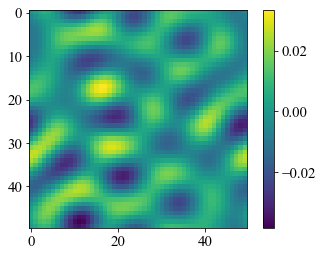

In [373]:
plt.imshow(field_21_cm) #mK
plt.colorbar()

In [192]:
nbins = 30

power_spec_21 = pspec_copy.Power_Spectrum(field_21cm,Ly,Lx,nbins,0.15) #100 Mpc by 100M
p_21_true = power_spec_21.compute_2D_pspec()

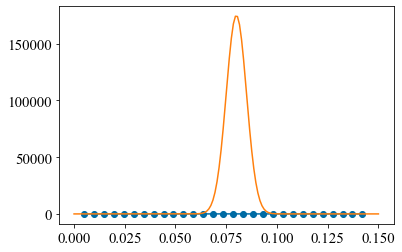

In [193]:
x = np.linspace(0,0.15,150)
plt.scatter(p_21_true[0],p_21_true[1])
plt.plot(p_21_true[0],p_21_true[1])
plt.plot(x,ps(x)*175000)

In [383]:
negative = -np.ones((50,50))
CII_field = field_21_cm*negative*8000

In [353]:
field_21cm = np.loadtxt("21cm_data.txt").reshape(50,50)
field_21cm /= 100

CII_field = np.loadtxt("CII_data.txt").reshape(50,50)

Text(0.5, 0.98, '21 cm Field')

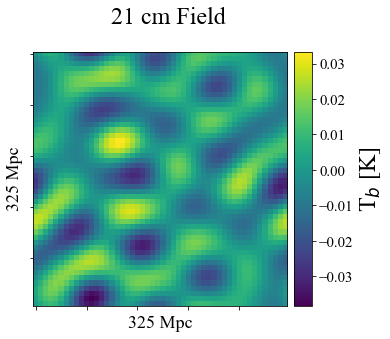

In [387]:

#try plotting log
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, figsize = (5,5))
img1 = ax.imshow(field_21_cm)
ax.set_xlabel('325 Mpc', fontsize = 18, labelpad = 10)
ax.set_ylabel('325 Mpc', fontsize = 18, labelpad = 10)


divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="7%", pad=0.1)
cbar = fig.colorbar(img1, cax=cax2)
cbar.set_label('T$_b$ [K]', fontsize = 24)


plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)




fig.suptitle('21 cm Field',fontsize=24)


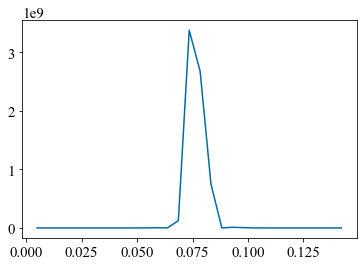

In [175]:
power_spec_CII = pspec_copy.Power_Spectrum(CII_field,Ly,Lx,nbins,0.15) #100 Mpc by 100M
p_CII_true = power_spec_CII.compute_2D_pspec()

plt.plot(p_CII_true[0],p_CII_true[1])

In [190]:
x_spec = cross_pspec.Cross_Spectrum(field_21cm,CII_field,Lx,Ly,nbins,0.15)
p_cross_true = x_spec.compute_2D_pspec()

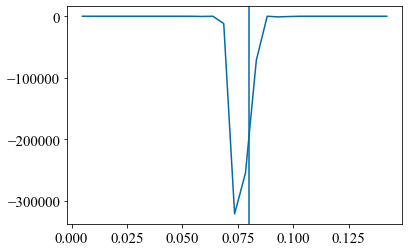

In [191]:
plt.plot(p_cross_true[0],p_cross_true[1])
plt.axvline(x = 0.08)

In [13]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    
def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

AttributeError: 'list' object has no attribute 'get_array'

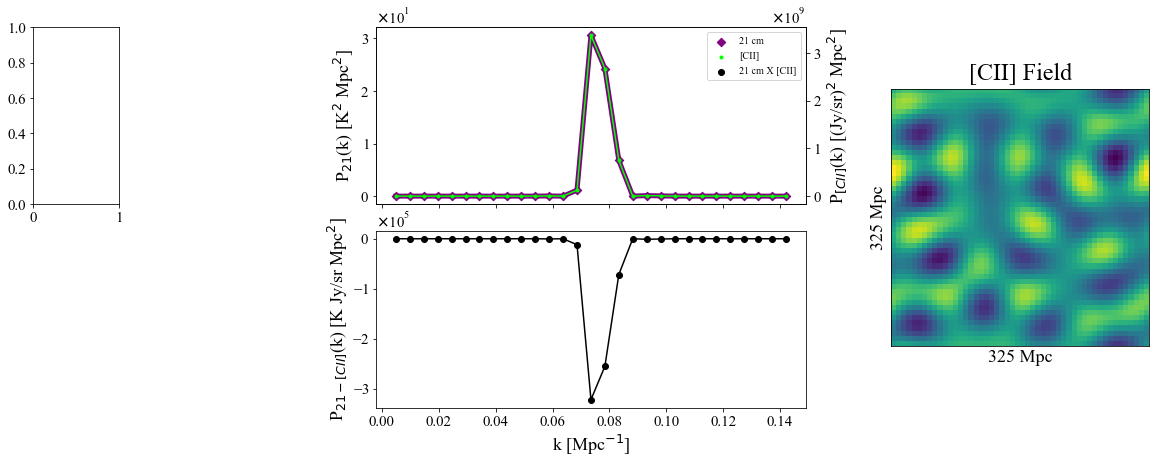

In [318]:


fig3 = plt.figure(figsize = (20,7),constrained_layout=False)
gs = fig3.add_gridspec(2, 7, hspace = 0.15,wspace=1)


f3_ax1 = fig3.add_subplot(gs[0:2, :2])
img1 = f3_ax1.imshow(field_21_cm)
f3_ax1.set_title('21 cm Field', fontsize = 24, y = 1.01)
f3_ax1.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
f3_ax1.set_xlabel('325 Mpc', fontsize = 18)
f3_ax1.set_ylabel('325 Mpc', fontsize = 18)



f3_ax2 = fig3.add_subplot(gs[0, 2:5])
line_21 = f3_ax2.scatter(p_21_true[0],p_21_true[1],marker = 'D', color = 'purple' ,label = '21 cm')
f3_ax2.plot(p_21_true[0],p_21_true[1], color = 'purple', linewidth = 5,label = '21 cm')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
f3_ax2.yaxis.set_major_formatter(formatter)


f3_ax3 = f3_ax2.twinx()

line_CII = f3_ax3.scatter(p_CII_true[0],p_CII_true[1], marker = '.',color = 'lime', label = '[CII]')
f3_ax3.plot(p_CII_true[0],p_CII_true[1], color = 'lime', label = '[CII]')
f3_ax3.set_ylabel('P$_{[CII]}$(k) [(Jy/sr)$^2$ Mpc$^2$]',fontsize = 18)
f3_ax2.set_ylabel('P$_{21}$(k) [K$^2$ Mpc$^2$]',fontsize = 18)





f3_ax4 = fig3.add_subplot(gs[1, 2:5])
line_cross = f3_ax4.scatter(p_cross_true[0],p_cross_true[1], color = 'k',label = '21 cm X [CII]')
f3_ax4.plot(p_cross_true[0],p_cross_true[1], color = 'k',label = '21 cm X [CII]')
f3_ax4.set_xlabel('k [Mpc$^{-1}$]', fontsize = 18)
f3_ax4.set_ylabel('P$_{21-[CII]}$(k) [K Jy/sr Mpc$^2$]',fontsize = 18)
f3_ax4.yaxis.set_major_formatter(formatter)
f3_ax3.yaxis.set_major_formatter(formatter)



align_yaxis_np(f3_ax3, f3_ax2)

f3_ax5 = fig3.add_subplot(gs[0:2, 5:7])
f3_ax5.set_title('gs[0, :]')
img3 = f3_ax5.imshow(CII_field)
f3_ax5.set_title('[CII] Field', fontsize = 24, y = 1.01)
f3_ax5.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
f3_ax5.set_xlabel('325 Mpc', fontsize = 18)
f3_ax5.set_ylabel('325 Mpc', fontsize = 18)

line_labels = ['21 cm','[CII]','21 cm X [CII]']
f3_ax2.legend([line_21,line_CII,line_cross], line_labels )
plt.style.use('tableau-colorblind10')
plt.setp(f3_ax2.get_xticklabels(), visible=False)


# and let us not forget the colorbar  above !
# --------------------------------------------------------
cbax = plt.subplot(gs[0,0]) # Place it where it should be.
# --------------------------------------------------------

cb = Colorbar(ax = cbax, mappable = plt1, orientation = 'horizontal', ticklocation = 'top')
cb.set_label(r'Colorbar !', labelpad=10)

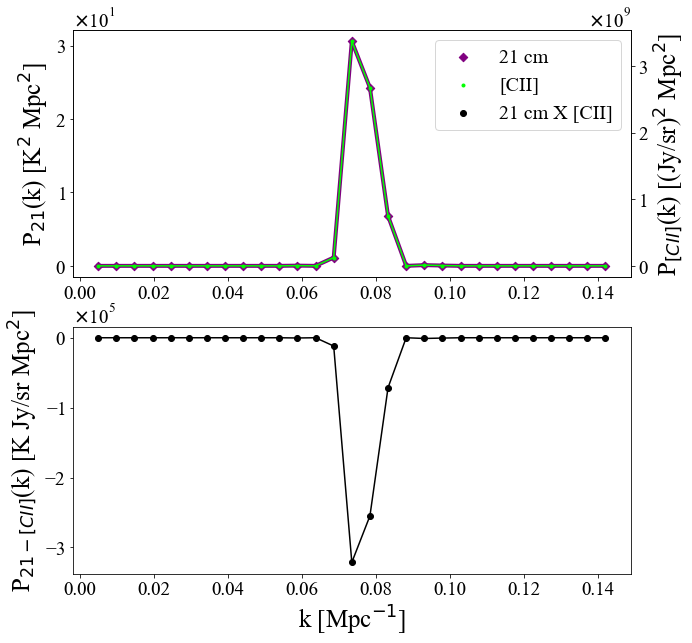

In [405]:
from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?


fig3 = plt.figure(figsize = (10,10),constrained_layout=False)
gs = fig3.add_gridspec(2, 1, hspace = 0.2,wspace=0.3, )





f3_ax2 = fig3.add_subplot(gs[0, 0])
line_21 = f3_ax2.scatter(p_21_true[0],p_21_true[1],marker = 'D', color = 'purple' ,label = '21 cm')
f3_ax2.plot(p_21_true[0],p_21_true[1], color = 'purple',linewidth = 4,label = '21 cm')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
f3_ax2.yaxis.set_major_formatter(formatter)


f3_ax3 = f3_ax2.twinx()

line_CII = f3_ax3.scatter(p_CII_true[0],p_CII_true[1], marker = '.',color = 'lime', label = '[CII]')
f3_ax3.plot(p_CII_true[0],p_CII_true[1], color = 'lime', label = '[CII]')
f3_ax3.set_ylabel('P$_{[CII]}$(k) [(Jy/sr)$^2$ Mpc$^2$]',fontsize = 25)
f3_ax2.set_ylabel('P$_{21}$(k) [K$^2$ Mpc$^2$]',fontsize = 25)





f3_ax4 = fig3.add_subplot(gs[1, 0])
line_cross = f3_ax4.scatter(p_cross_true[0],p_cross_true[1], color = 'k',label = '21 cm X [CII]')
f3_ax4.plot(p_cross_true[0],p_cross_true[1], color = 'k',label = '21 cm X [CII]')
f3_ax4.set_xlabel('k [Mpc$^{-1}$]', fontsize = 25)
f3_ax4.set_ylabel('P$_{21-[CII]}$(k) [K Jy/sr Mpc$^2$]',fontsize = 25)
f3_ax4.yaxis.set_major_formatter(formatter)
f3_ax3.yaxis.set_major_formatter(formatter)

line_labels = ['21 cm','[CII]','21 cm X [CII]']
f3_ax2.legend([line_21,line_CII,line_cross], line_labels, fontsize = 20)

In [170]:
CII_data = open("CII_data.txt", "w")

for row in CII_field:
    np.savetxt(CII_data, row)

CII_data.close()

data_21cm = open("21cm_data.txt", "w")

for row in field_21_cm:
    np.savetxt(data_21cm, row)

data_21cm.close()

# Window Functions

## HERA

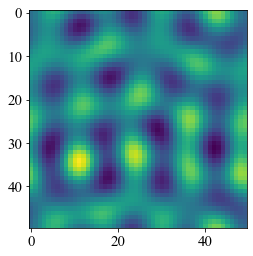

In [177]:
field_21cm = np.loadtxt("21cm_data.txt").reshape(50,50)
field_21cm /= 100

plt.imshow(field_21cm)

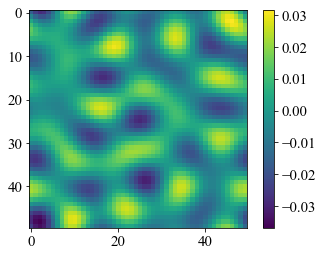

In [268]:
cov_spec_21cm = np.zeros((npix_row*npix_col),dtype = complex)

nreals = 1

for i in range(nreals): 
    
    universe = make_uni.make_2D_universe()
    plt.imshow(universe)
    plt.colorbar()

    power_spec_stdev = pspec_copy.Power_Spectrum(universe,Ly,Lx,nbins,False) #100 Mpc by 100M
    power_spec_stdev.cosmo_FFT2()
    spec_cov = np.reshape(power_spec_stdev.ps_data, (2500,))
    cov_spec_21cm += spec_cov #find the average spec


In [257]:
ave_cov_spec_21cm = cov_spec_21cm / nreals
window_21 = window_function_2.Window_Function(obs.Mmat,M_ccat,npix_row,npix_col,Lx,Ly,140,nbins)
window_HERA = window_21.compute_pspec_estimate(ave_cov_spec_21cm)
window_HERA = np.nan_to_num(window_HERA)

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:162: RuntimeWarning: invalid value encountered in cdouble_scalars
  


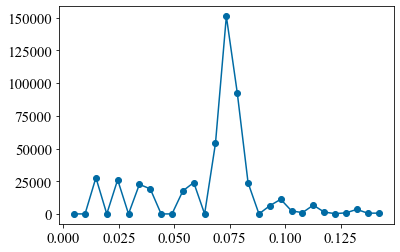

In [258]:
plt.scatter(window_HERA[0],window_HERA[1])
plt.plot(window_HERA[0],window_HERA[1])

In [263]:
HERA_window = open("HERA_window.txt", "w")

for row in window_HERA:
    np.savetxt(HERA_window, row)

HERA_window.close()

## CCAT

In [234]:
RA = np.linspace(0,0.0349066,50) #rads (2 deg by 2 deg) 
DEC = np.linspace(0,0.0349066,50) #rads (2 deg by 2 deg) 

delta_RA = (RA[1]-RA[0])
delta_DEC = (DEC[1]-DEC[0])
omega_pix = np.abs((RA[1]-RA[0])*(DEC[1]-DEC[0])) #in sr


noisy_convolve = CCAT_p(CII_field,RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75) 

In [241]:
G = np.reshape(noisy_convolve,2500)
M_ccat = np.diag(G)

In [249]:
cov_spec_CII = np.zeros((npix_row*npix_col),dtype = complex)

nreals = 100

for i in range(nreals): 
    
    universe = make_uni.make_2D_universe()
    universe *= (-8000)
    
    power_spec_stdev = pspec_copy.Power_Spectrum(universe,Ly,Lx,nbins,False) #100 Mpc by 100M
    power_spec_stdev.cosmo_FFT2()
    spec_cov = np.reshape(power_spec_stdev.ps_data, (2500,))
    cov_spec_CII += spec_cov #find the average spec

In [261]:
ave_cov_spec_CII= cov_spec_CII / nreals
window_CII = window_function_2.Window_Function(M_ccat,M_ccat,npix_row,npix_col,Lx,Ly,140,nbins)
window_CCAT = window_CII.compute_pspec_estimate(ave_cov_spec_CII)
window_CCAT = np.nan_to_num(window_CCAT)

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  self.pk_window_binned[i] = a/c #compute average W that bin
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:162: RuntimeWarning: invalid value encountered in cdouble_scalars
  self.pk_window_binned[i] = a/c #compute average W that bin


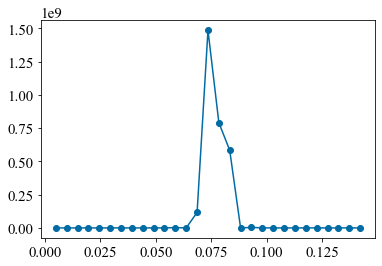

In [262]:
plt.scatter(window_CCAT[0],window_CCAT[1])
plt.plot(window_CCAT[0],window_CCAT[1])

In [264]:
CCAT_window = open("CCAT_window.txt", "w")

for row in window_CCAT:
    np.savetxt(CCAT_window, row)

CCAT_window.close()

## Cross Window 

In [251]:
cov_spec_cross = np.zeros((npix_row*npix_col),dtype = complex)

nreals = 100

for i in range(nreals): 
    
    field_21 = make_uni.make_2D_universe()
    CII_field = field_21*(-8000)
    
    x_spec = cross_pspec.Cross_Spectrum(CII_field,field_21,Lx,Ly,nbins,0.15) ## DATA1 np.conj
    p_cross = x_spec.compute_2D_pspec()
    spec_cov = np.reshape(x_spec.ps_data, (2500,))
    cov_spec_cross += spec_cov #find the average spec

In [254]:
ave_cov_spec_cross= cov_spec_cross / nreals
window_21_CII = window_function_2.Window_Function(obs.Mmat,M_ccat,npix_row,npix_col,Lx,Ly,140,nbins)
window_cross = window_21_CII.compute_pspec_estimate(ave_cov_spec_cross)
window_cross = np.nan_to_num(window_cross)

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:162: RuntimeWarning: invalid value encountered in cdouble_scalars
  


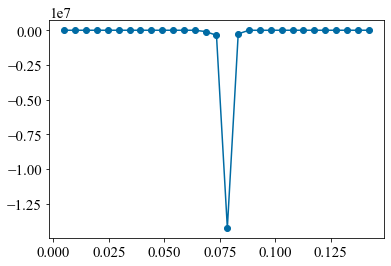

In [255]:
plt.scatter(window_cross[0],window_cross[1])
plt.plot(window_cross[0],window_cross[1])

In [265]:
cross_window = open("cross_window.txt", "w")

for row in window_cross:
    np.savetxt(cross_window, row)

cross_window.close()